# Feature evaluation
This notebook explores the engeineered features.

## Load dependencies

In [2]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from definitions import GEN_PATH, ROOT_DIR

sns.set_context('notebook')
sns.set_style('white')

## Load processed data

In [3]:
# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

## Extract training and validation data
Test data should not be used, even in, feature evaluation.

In [4]:
# Split data set into train and test
# Start of 2019 season in unix time, 2018-12-31 00:00:00 UTC
test_date_begin = 1546214400

# Testing will be done on 2019 matches
data_train = data.loc[data.tourney_date < test_date_begin]
data_train = pd.get_dummies(data_train, columns=['home_advantage'])

renames = {
    'home_advantage_-1.0': 'p2_home',
    'home_advantage_0.0': 'none_home',
    'home_advantage_1.0': 'p1_home',
}

data_train.rename(columns=renames, inplace=True)

data_train.dropna(inplace=True)

## OPTIONAL: Removing low level matches
Testing to remove low level matches to see if different
is present for tour level matches. This means train and evaluate 
on only tour matches

In [11]:
tourneys = [2,3,5,6]
data_mask = (data_train.tourney_level.isin(tourneys))
data_train = data_train.loc[data_mask]

## Split data set into validation and training part

In [9]:
drop_cols = ['outcome', 'tourney_date', 'player_1', 'player_2']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

# Fource tourney level to represent difficulty
X_train.tourney_level[X_train.tourney_level == 4] = 3
X_train.tourney_level[X_train.tourney_level == 5] = 4
X_train.tourney_level[X_train.tourney_level == 6] = 4

scale_cols = ['tourney_level', 'age_diff']
X_train[scale_cols] = StandardScaler().fit_transform(X_train[scale_cols])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

display(X_train)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,age_diff,tourney_level,surface,p2_home,none_home,p1_home
13005,-0.328981,-0.372376,1.443146,1.522080,2.290345,0.138407,-0.035488,-0.092580,0.004406,0.000408,0.471601,-0.645229,0.0,0,1,0
38678,-0.605043,-0.652218,-0.000751,-0.000729,0.000642,0.263015,-0.138409,-0.902241,-2.890145,0.000408,-0.279647,-0.645229,0.0,0,1,0
62320,0.223142,-0.185814,0.265753,0.442694,2.460596,-0.070811,1.937613,-0.425970,-0.062909,-2.326092,1.977675,1.489619,2.0,0,1,0
63574,-0.108132,0.280591,0.134490,0.396018,-0.235625,-0.140037,0.518388,0.097928,0.509270,0.410967,-0.930729,0.422195,2.0,0,1,0
61359,0.664842,0.700355,-0.000751,-0.000729,0.000642,-1.026136,0.014618,0.574199,0.004406,0.000408,0.764946,-0.645229,2.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,0.664842,1.026839,-0.000751,-0.000729,0.000642,-1.006137,0.280045,-0.378343,-0.332169,0.274114,-0.225987,-0.645229,2.0,0,1,0
55010,-0.218557,-2.611118,-0.000751,-0.000729,0.000642,1.202956,-0.023300,-0.283089,-0.163882,0.000408,-1.789299,-0.645229,2.0,0,1,0
76963,-0.439406,-2.331275,-0.000751,-0.000729,0.000642,0.055335,-0.856147,-0.330716,1.418024,0.000408,-0.648117,3.624468,1.0,0,1,0
863,-0.439406,-0.325735,-0.000751,-0.000729,0.000642,0.044567,-0.948234,-0.997495,-0.433142,0.000408,1.281876,3.624468,2.0,0,1,0


## OPTIONAL: Remove correlated features

In [15]:
col_remove = ['rel_total_wins', 'mutual_wins', 'mutual_surface_wins', 'rel_climate_wins']
X_train.drop(col_remove, inplace=True, axis=1)
X_val.drop(col_remove, inplace=True, axis=1)

## Correlation heatmap

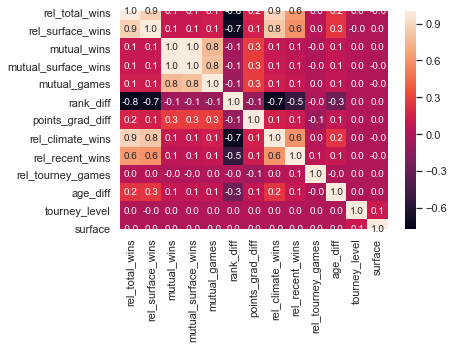

In [10]:
adv = ['p2_home', 'none_home', 'p1_home']
X_heat = X_train.drop(adv, axis=1)
sns.heatmap(X_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance
Question being answered: which features help split our tree in the best way possible?
How does each feature affect the accuracy of our model?

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


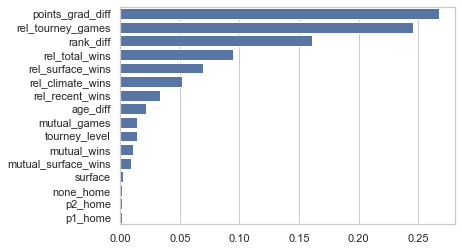

In [13]:
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

sns.set(style="whitegrid")
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp = feat_imp.sort_values(ascending=False)
sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
plt.show()

## Recursive feature elimination by feature importance
This takes a bit of time (large set...). 
Prune the results from previous sections. 
A ranking of 1 means the algorithm suggests the feature.
Remove highly correlated feature first

In [14]:
model = RandomForestClassifier(max_depth=10)
rfe_model = RFE(model)  # selects 5 features
rfe_model.fit(X_train, y_train)

rfe_results = pd.DataFrame(rfe_model.ranking_, index=X_train.columns, columns=['ranking'])

display(rfe_results)
print('\nNumber of features selected: %d' % rfe_model.n_features_)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Jon/opt/anaconda3/lib/python3

,ranking
rel_total_wins,1
rel_surface_wins,1
mutual_wins,5
mutual_surface_wins,3
mutual_games,4
rank_diff,1
points_grad_diff,1
rel_climate_wins,1
rel_recent_wins,1
rel_tourney_games,1



Number of features selected: 8


## Classification report

Full model:

In [16]:
model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.73      0.74      0.73     15101
         1.0       0.74      0.72      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174



Reduced model:
Run script above due to it being so slow

In [18]:
red_val_pred = rfe_model.predict(X_val)
class_report_red = classification_report(y_val, red_val_pred)
print(class_report_red)

              precision    recall  f1-score   support

        -1.0       0.73      0.73      0.73     15101
         1.0       0.73      0.73      0.73     15073

    accuracy                           0.73     30174
   macro avg       0.73      0.73      0.73     30174
weighted avg       0.73      0.73      0.73     30174



## Performance on ATP main matches
Same matches as being tested, ATP 250, 500 and 1000

In [33]:
tourneys = [2,3]

drop_cols = ['outcome', 'tourney_date', 'player_1', 'player_2', 'p1_home', 'p2_home', 'none_home', 'surface', 'mutual_surface_wins', 'mutual_games', 'mutual_wins']
y_train = data_train.outcome
X_train = data_train.drop(drop_cols, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

X_val = X_val.join(y_val)
data_mask = (X_val.tourney_level.isin(tourneys))
X_val = X_val.loc[data_mask]
y_val = X_val.outcome
X_val.drop(['outcome', 'tourney_level'], inplace=True, axis=1)

X_train.drop('tourney_level', inplace=True, axis=1)

model = RandomForestClassifier(max_depth=10)
model.fit(X_train, y_train)

print(X_train.columns)

full_val_pred = model.predict(X_val)
class_report_full = classification_report(y_val, full_val_pred)
print(class_report_full)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Index(['rel_total_wins', 'rel_surface_wins', 'rank_diff', 'points_grad_diff',
       'rel_climate_wins', 'rel_recent_wins', 'rel_tourney_games', 'age_diff'],
      dtype='object')
              precision    recall  f1-score   support

        -1.0       0.66      0.66      0.66      1299
         1.0       0.67      0.67      0.67      1362

    accuracy                           0.66      2661
   macro avg       0.66      0.66      0.66      2661
weighted avg       0.66      0.66      0.66      2661



## Accuracy increase over time?
i.e. should we generate more statistics?

In [30]:
drop_cols = ['outcome', 'tourney_date', 'player_1', 'player_2', 'p1_home', 'p2_home', 'none_home', 'surface', 'mutual_surface_wins', 'mutual_games', 'tourney_level', 'mutual_wins']

# 2017-06-15
train_eval_split_low = 1497484800
train_eval_split_high = 1497484800

data_train_pre = data_train.loc[data_train.tourney_date < train_eval_split_low]
data_train_post = data_train.loc[data_train.tourney_date >= train_eval_split_high]

y_train_pre = data_train_pre.outcome
X_train_pre = data_train_pre.drop(drop_cols, axis=1)

y_train_post = data_train_post.outcome
X_train_post = data_train_post.drop(drop_cols, axis=1)

X_train_pre, X_val_pre, y_train_pre, y_val_pre = train_test_split(X_train_pre, y_train_pre, test_size=0.33, random_state=42)
X_train_post, X_val_post, y_train_post, y_val_post = train_test_split(X_train_post, y_train_post, test_size=0.33, random_state=42)

model_pre = RandomForestClassifier(max_depth=10)
model_pre.fit(X_train_pre, y_train_pre)

val_pred_pre = model_pre.predict(X_val_pre)
class_report_pre = classification_report(y_val_pre, val_pred_pre)
print(class_report_pre)

model_post = RandomForestClassifier(max_depth=10)
model_post.fit(X_train_post, y_train_post)

val_pred_post = model_post.predict(X_val_post)
class_report_post = classification_report(y_val_post, val_pred_post)
print(class_report_post)

/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.73      0.72      0.73      7322
         1.0       0.73      0.74      0.74      7488

    accuracy                           0.73     14810
   macro avg       0.73      0.73      0.73     14810
weighted avg       0.73      0.73      0.73     14810



/Users/Jon/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        -1.0       0.73      0.72      0.72      7810
         1.0       0.71      0.72      0.72      7555

    accuracy                           0.72     15365
   macro avg       0.72      0.72      0.72     15365
weighted avg       0.72      0.72      0.72     15365

